# Dataset size comparison

**Goal:** ...
  
This notebook is divided in two parts:
* **1. Bla**

In [1]:
%run ../setup_environment.ipy
%run ../Selene_Job.ipy

Setup environment... done!


<span style="color:green">✅ Working on **impact-annotator_env** conda environment.</span>

In [2]:
summary = pd.DataFrame(columns=['test_accuracy', 'test_roc_auc', 'test_f1', 'test_average_precision'])
summary.index.name = 'sampling_strategy'

## Get the data

In [4]:
# get raw data
impact = pd.read_csv('../../../data/annotated_final_IMPACT_mutations_180508.txt', sep='\t', low_memory=False)

In [5]:
get_table(impact.confidence_class)

,count_,freq_
AUTO_OK,180832,93.1%
UNLIKELY,7199,3.7%
MANUAL_OK,6180,3.2%


In [6]:
# create the is_artefact class
impact['is_artefact'] = impact.confidence_class == "UNLIKELY"
get_table(impact.is_artefact)

,count_,freq_
False,187012,96.3%
True,7199,3.7%


In [7]:
# choose label
label = 'is_artefact'

# choose features
features = ['t_depth', 't_vaf', 't_alt_count', 'n_depth', 'n_vaf', 'n_alt_count', 'sample_coverage', 'frequency_in_normals',
            'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_COSMIC_CNT', 'VEP_gnomAD_AF', 'VEP_in_dbSNP',
            'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN',
            'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF', 'Kaviar_AF',
            'gene_type']
impact = impact[features + [label]].dropna()
    
# transform categorical features
categorical_features = ['VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_in_dbSNP', 'gene_type']
numerical_features = [f for f in features if not f in categorical_features]
impact = pd.get_dummies(impact, columns=categorical_features, sparse=True)

In [8]:
def get_X_and_y(seed):
    # get selected dataset
    positive_class_number = impact[impact.is_artefact].shape[0]
    impact_selected = pd.concat([impact[impact.is_artefact],
                                 impact[~impact.is_artefact].iloc[seed * positive_class_number:(seed + 1) * positive_class_number]], ignore_index=True)

    # shuffle data
    rng = np.random.RandomState(42)
    permutation = rng.permutation(len(impact_selected))
    impact_selected = impact_selected.iloc[permutation]
    impact_selected.reset_index(drop=True, inplace=True)

    # get features matrix X (n_samples x n_features) and target array y (n_samples)
    X = impact_selected.drop(label, axis=1)
    X = X.astype(float)
    y = impact_selected[label]

    print(X.shape)
    print(y.shape)
    display(get_table(y))
    
    return (X, y)

In [9]:
X_1, y_1 = get_X_and_y(0)
X_2, y_2 = get_X_and_y(1)
X_3, y_3 = get_X_and_y(2)

(14398, 45)
(14398,)


,count_,freq_
True,7199,50.0%
False,7199,50.0%


(14398, 45)
(14398,)


,count_,freq_
True,7199,50.0%
False,7199,50.0%


(14398, 45)
(14398,)


,count_,freq_
True,7199,50.0%
False,7199,50.0%


In [10]:
dataset_dict = {'sampling_1': (X_1, y_1),
                'sampling_2': (X_2, y_2),
                'sampling_3': (X_3, y_3)}

## Set cross-validation strategies

We choose stratified folds (made by preserving the percentage of samples for each class) for both outer and nested cross-validation.

In [11]:
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

## Ridge Regression (L2 regularization)

In [19]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

model = Pipeline([('scale'   , StandardScaler()),
                  ('classify', LogisticRegressionCV(cv=nested_cv_strategy, scoring='roc_auc', random_state=42))])

metrics_dict = {}
for dataset_name, (X, y) in dataset_dict.items():
    print_md('**' + dataset_name + '**')
    metrics_dict[dataset_name] = run_model(model, X, y, cv_strategy, n_jobs=5)  
    print_mean_metrics(metrics_dict[dataset_name])

**sampling_1**

Run model... done! (5.55s)
▴ Mean accuracy    : 0.820 ± 0.006
▴ Mean ROC AUC     : 0.891 ± 0.010
▴ Mean F1-score    : 0.803 ± 0.011
▴ Average precision: 0.912 ± 0.006


**sampling_2**

Run model... done! (4.22s)
▴ Mean accuracy    : 0.819 ± 0.020
▴ Mean ROC AUC     : 0.887 ± 0.019
▴ Mean F1-score    : 0.801 ± 0.022
▴ Average precision: 0.912 ± 0.015


**sampling_3**

Run model... done! (4.62s)
▴ Mean accuracy    : 0.866 ± 0.016
▴ Mean ROC AUC     : 0.926 ± 0.016
▴ Mean F1-score    : 0.858 ± 0.019
▴ Average precision: 0.943 ± 0.012


**sampling_1**

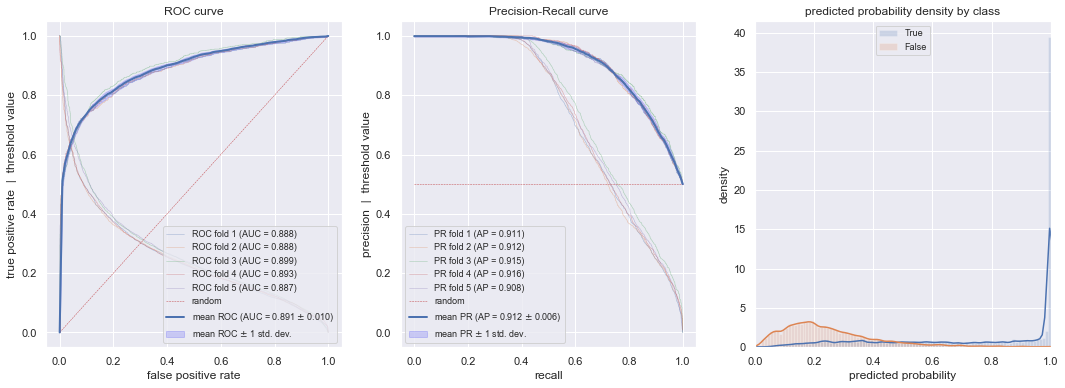

**sampling_2**

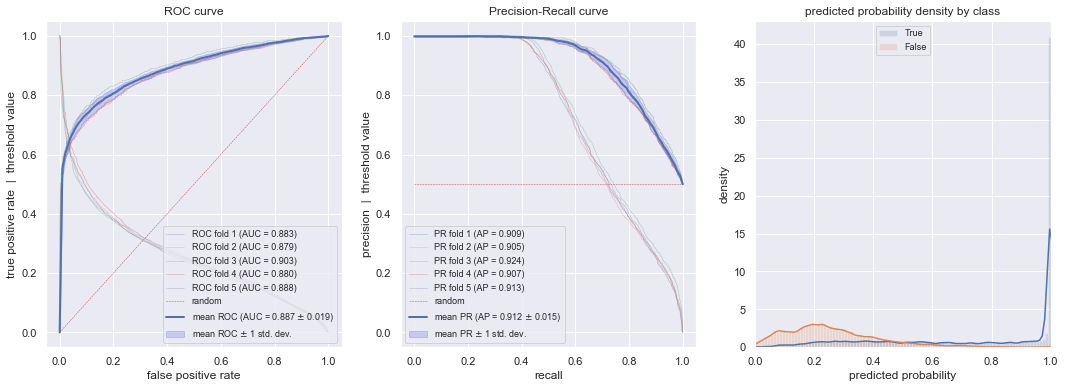

**sampling_3**

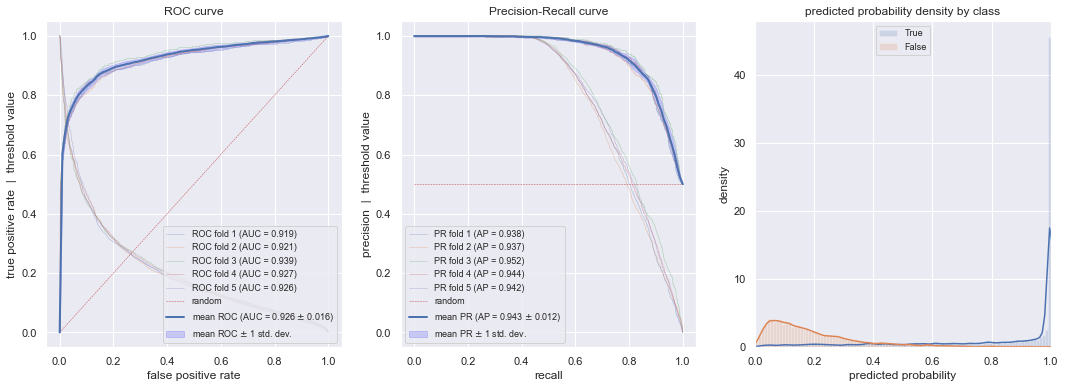

In [20]:
for dataset_name, metrics in metrics_dict.items():
    print_md('**' + dataset_name + '**')
    plot_threshold_decision_metrics(metrics, figsize=(18, 6))
    plt.show()

**sampling_1**

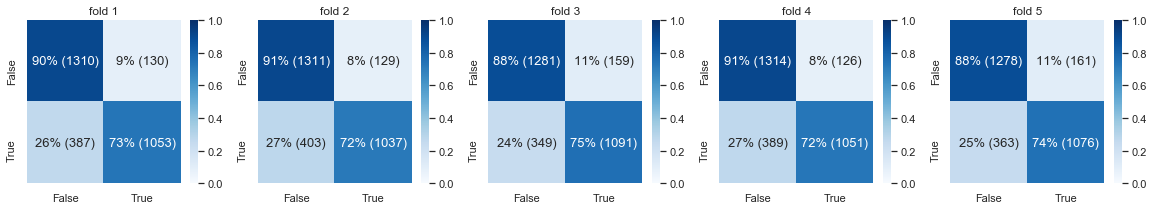

**sampling_2**

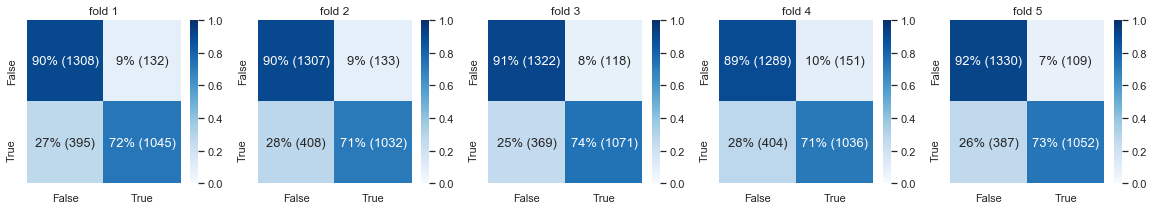

**sampling_3**

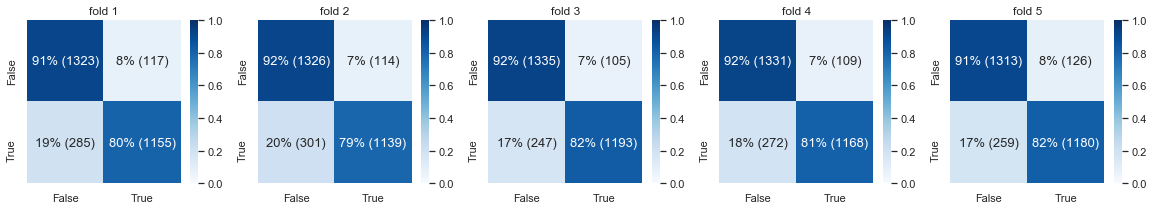

In [21]:
for dataset_name, metrics in metrics_dict.items():
    print_md('**' + dataset_name + '**')
    plot_confusion_matrix(metrics)
    plt.show()

In [22]:
for dataset_name, metrics in metrics_dict.items():
    summary.loc['RidgeRegression_%s' % dataset_name] = [metrics.test_accuracy.mean(), metrics.test_roc_auc.mean(), metrics.test_f1.mean(), metrics.test_average_precision.mean()]

## Random Forest

### Create job

In [28]:
job_list = []
for name in dataset_dict.keys():
    job_list.append(Selene_Job('RandomForest_%s' % name, 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs'))

➞ mkdir on local computer ../ssh_remote_jobs/job_RandomForest_sampling_1


<span style="color:green">Job < RandomForest_sampling_1 >: </span>✅ created

➞ mkdir on local computer ../ssh_remote_jobs/job_RandomForest_sampling_2


<span style="color:green">Job < RandomForest_sampling_2 >: </span>✅ created

➞ mkdir on local computer ../ssh_remote_jobs/job_RandomForest_sampling_3


<span style="color:green">Job < RandomForest_sampling_3 >: </span>✅ created

In [29]:
job_list = []
for name in dataset_dict.keys():
    job_list.append(Selene_Job('RandomForest_%s' % name, 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True))

<span style="color:green">Job < RandomForest_sampling_1 >: </span>✅ job found and reloaded

<span style="color:green">Job < RandomForest_sampling_2 >: </span>✅ job found and reloaded

<span style="color:green">Job < RandomForest_sampling_3 >: </span>✅ job found and reloaded

In [30]:
for job in job_list:
    X, y = dataset_dict[job.job_id[13:]]
    display(get_table(y))
    job.load_data(X, y)

,count_,freq_
True,7199,50.0%
False,7199,50.0%


➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_RandomForest_sampling_1


<span style="color:green">Job < RandomForest_sampling_1 >: </span>✅ data loaded

,count_,freq_
True,7199,50.0%
False,7199,50.0%


➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_RandomForest_sampling_2


<span style="color:green">Job < RandomForest_sampling_2 >: </span>✅ data loaded

,count_,freq_
True,7199,50.0%
False,7199,50.0%


➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_RandomForest_sampling_3


<span style="color:green">Job < RandomForest_sampling_3 >: </span>✅ data loaded

In [31]:
%%writefile {job_list[0].script_path}

# load the ml_tools functions
%run ../../ml_tools.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# setup cross-validation and import modules
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

# choose a model and run it
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
parameters_grid = [
    {'n_estimators': [100, 500, 1000, 1500], 'criterion': ['gini', 'entropy'], 'max_depth': [10, 20, 30, 40, 50, 100]}
]
model = GridSearchCV(RandomForestClassifier(random_state=42), parameters_grid, cv=nested_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)
metrics = run_model(model, X, y, cv_strategy, n_jobs=20)

# save the metrics
print('Save metrics...', end='')
metrics.to_pickle('metrics.pkl')
print(' done!')

Writing ../ssh_remote_jobs/job_RandomForest_sampling_1/script.ipy


In [32]:
!cp {job_list[0].script_path} {job_list[1].script_path}
!cp {job_list[0].script_path} {job_list[2].script_path}

In [33]:
for job in job_list:
        job.run(n_jobs=20, short_job=False, memory=32)

➞ scp ../ssh_remote_jobs/job_RandomForest_sampling_1 to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.ipy                                    100%  930   136.4KB/s   00:00    
X.pkl                                         100% 3268KB  14.1MB/s   00:00    
y.pkl                                         100%   15KB   2.1MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_sampling_1
Job <28689444> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J RandomForest_sampling_1 -n 20 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < RandomForest_sampling_1 >: </span>✅ submitted<br>

➞ scp ../ssh_remote_jobs/job_RandomForest_sampling_2 to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.ipy                                    100%  930   112.8KB/s   00:00    
X.pkl                                         100% 3268KB  13.4MB/s   00:00    
y.pkl                                         100%   15KB   1.4MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_sampling_2
Job <28689445> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J RandomForest_sampling_2 -n 20 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < RandomForest_sampling_2 >: </span>✅ submitted<br>

➞ scp ../ssh_remote_jobs/job_RandomForest_sampling_3 to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.ipy                                    100%  930   140.2KB/s   00:00    
X.pkl                                         100% 3268KB  13.8MB/s   00:00    
y.pkl                                         100%   15KB   1.8MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_sampling_3
Job <28689447> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J RandomForest_sampling_3 -n 20 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < RandomForest_sampling_3 >: </span>✅ submitted<br>

In [12]:
job_list = []
for name in dataset_dict.keys():
    job_list.append(Selene_Job('RandomForest_%s' % name, 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True))
    job_list[-1].get_results()

<span style="color:green">Job < RandomForest_sampling_1 >: </span>✅ job found and reloaded

<span style="color:green">Job < RandomForest_sampling_1 >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_sampling_1 to ../ssh_remote_jobs/job_RandomForest_sampling_1
metrics.pkl                                   100%  477KB   8.3MB/s   00:00    
job_output.txt                                100% 1535   178.2KB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy    : 0.864 ± 0.008
▴ Mean ROC AUC     : 0.937 ± 0.009
▴ Mean F1-score    : 0.859 ± 0.008
▴ Average precision: 0.948 ± 0.007


<span style="color:green">Job < RandomForest_sampling_2 >: </span>✅ job found and reloaded

<span style="color:green">Job < RandomForest_sampling_2 >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_sampling_2 to ../ssh_remote_jobs/job_RandomForest_sampling_2
metrics.pkl                                   100%  497KB   5.2MB/s   00:00    
job_output.txt                                100% 1535    81.5KB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy    : 0.860 ± 0.015
▴ Mean ROC AUC     : 0.933 ± 0.011
▴ Mean F1-score    : 0.853 ± 0.016
▴ Average precision: 0.944 ± 0.010


<span style="color:green">Job < RandomForest_sampling_3 >: </span>✅ job found and reloaded

<span style="color:green">Job < RandomForest_sampling_3 >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_sampling_3 to ../ssh_remote_jobs/job_RandomForest_sampling_3
metrics.pkl                                   100%  453KB   4.2MB/s   00:00    
job_output.txt                                100% 1535    87.4KB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy    : 0.896 ± 0.013
▴ Mean ROC AUC     : 0.958 ± 0.009
▴ Mean F1-score    : 0.894 ± 0.014
▴ Average precision: 0.964 ± 0.008


**RandomForest_sampling_1**

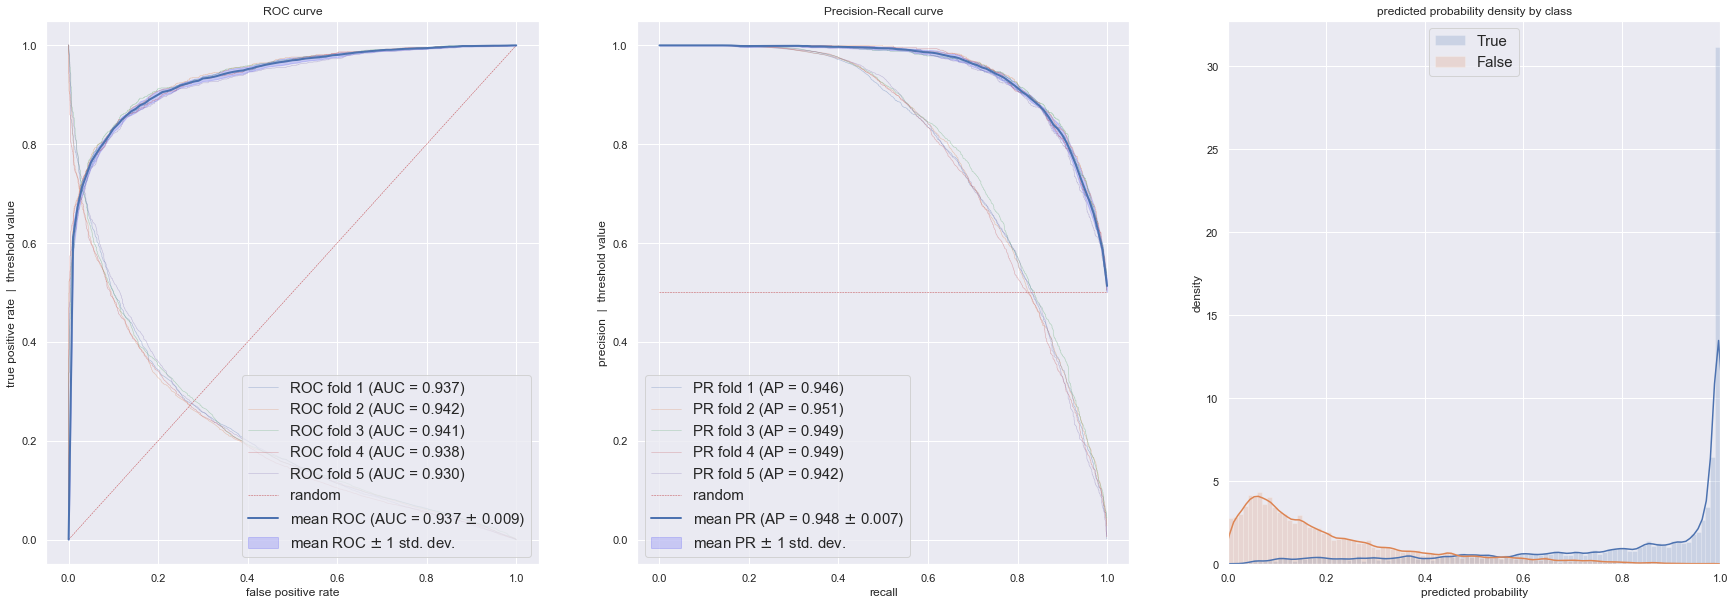

**RandomForest_sampling_2**

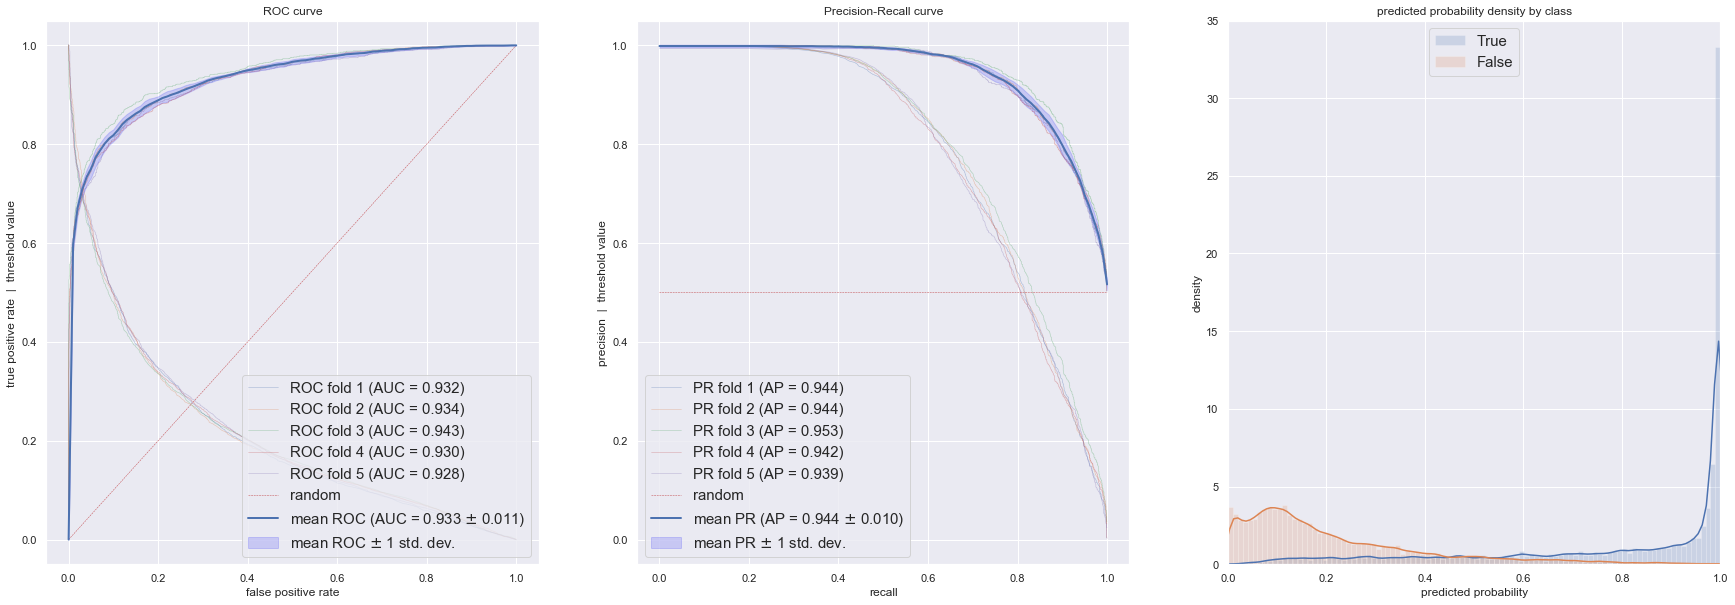

**RandomForest_sampling_3**

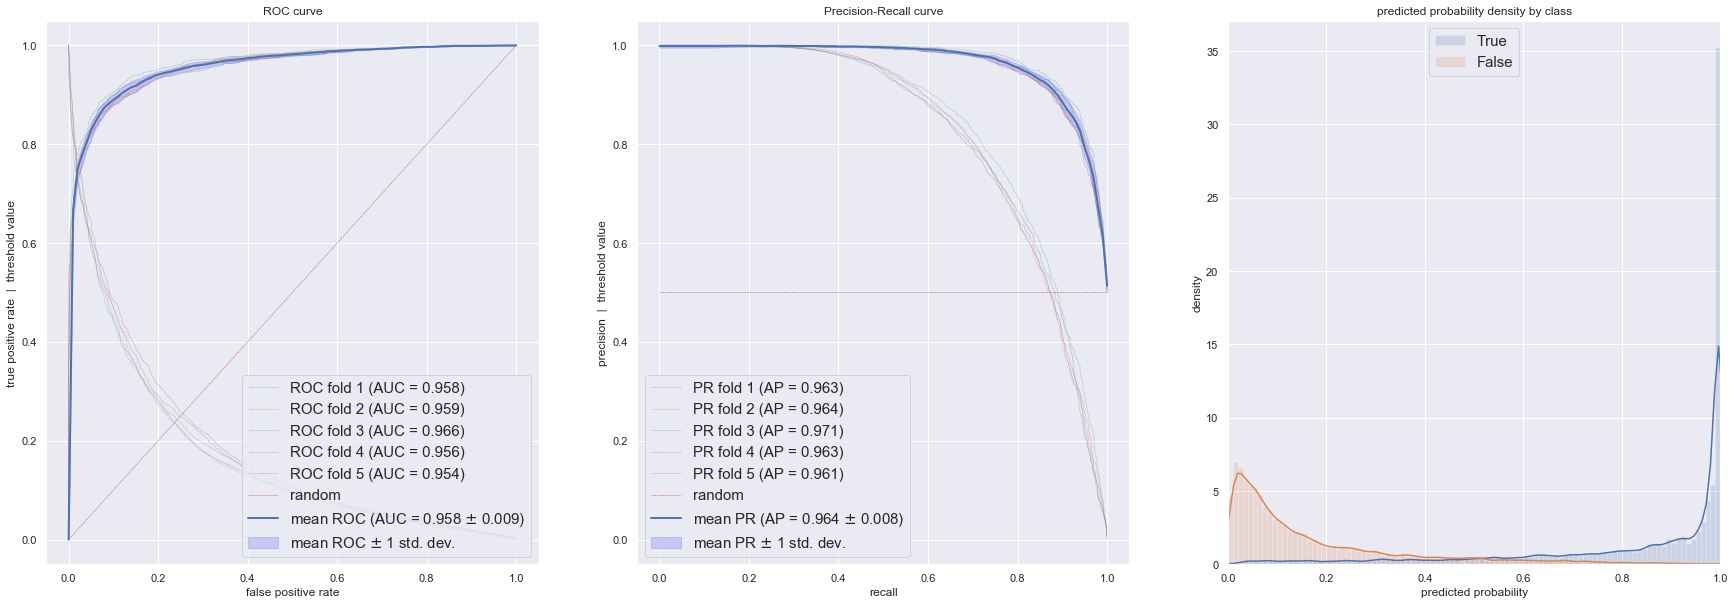

In [13]:
for job in job_list:
    if hasattr(job, 'metrics'):
        print_md('**' + job.job_id + '**')
        plot_threshold_decision_metrics(job.metrics)
        plt.show()

**RandomForest_sampling_1**

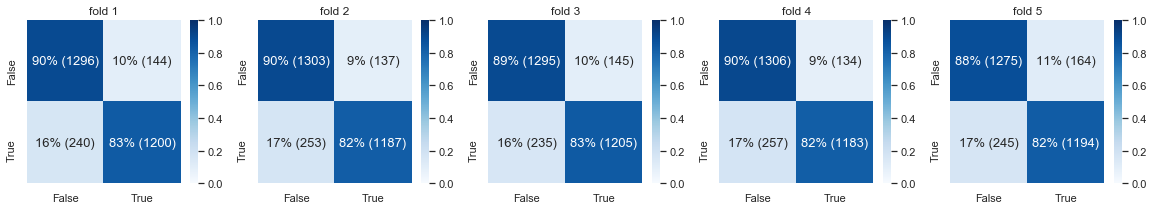

**RandomForest_sampling_2**

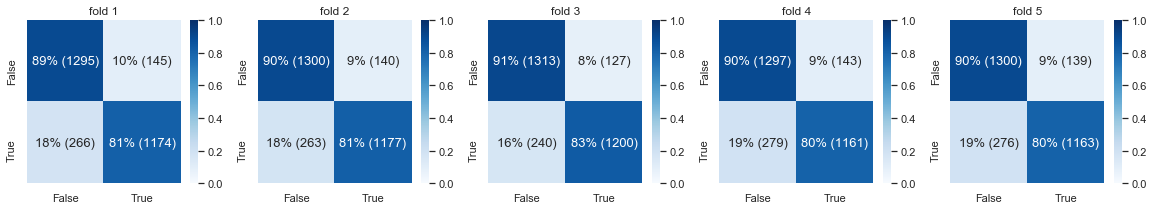

**RandomForest_sampling_3**

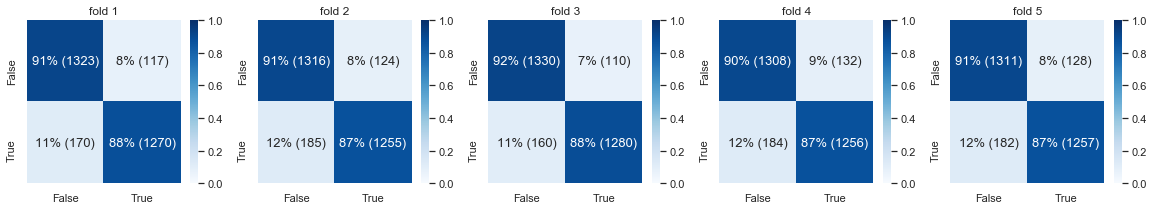

In [14]:
for job in job_list:
    if hasattr(job, 'metrics'):
        print_md('**' + job.job_id + '**')
        plot_confusion_matrix(job.metrics)
        plt.show()

**RandomForest_sampling_1**

3 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → criterion   : ['entropy' 'gini']
  → max_depth   : [10 20 30 40 50 100]
  → n_estimators: [100 500 1000 1500]
Best hyperparameters for each fold:
fold 0: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1500}
fold 1: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1500}
fold 2: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1000}
fold 3: {'criterion': 'entropy', 'max_depth': 40, 'n_estimators': 1500}
fold 4: {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 1000}


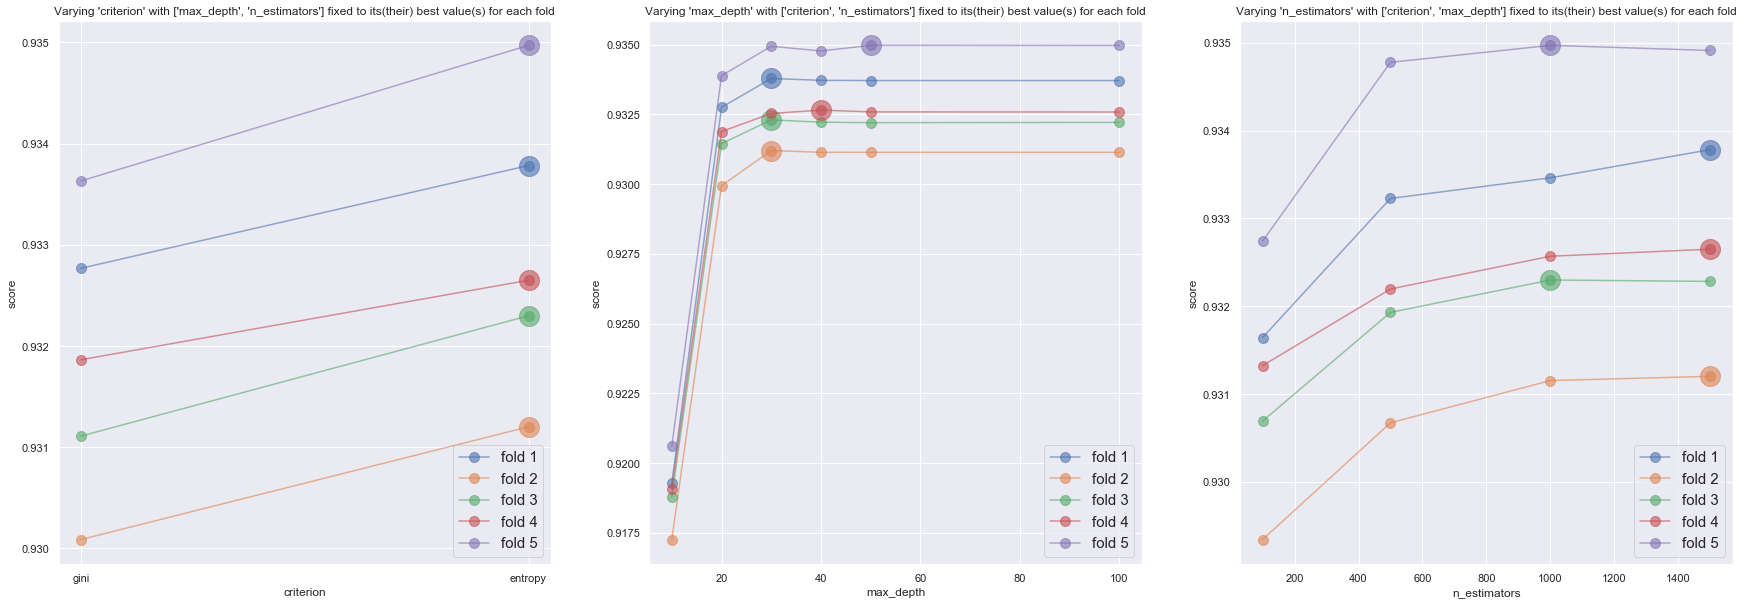

**RandomForest_sampling_2**

3 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → criterion   : ['entropy' 'gini']
  → max_depth   : [10 20 30 40 50 100]
  → n_estimators: [100 500 1000 1500]
Best hyperparameters for each fold:
fold 0: {'criterion': 'entropy', 'max_depth': 40, 'n_estimators': 1500}
fold 1: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1500}
fold 2: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1500}
fold 3: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1000}
fold 4: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 500}


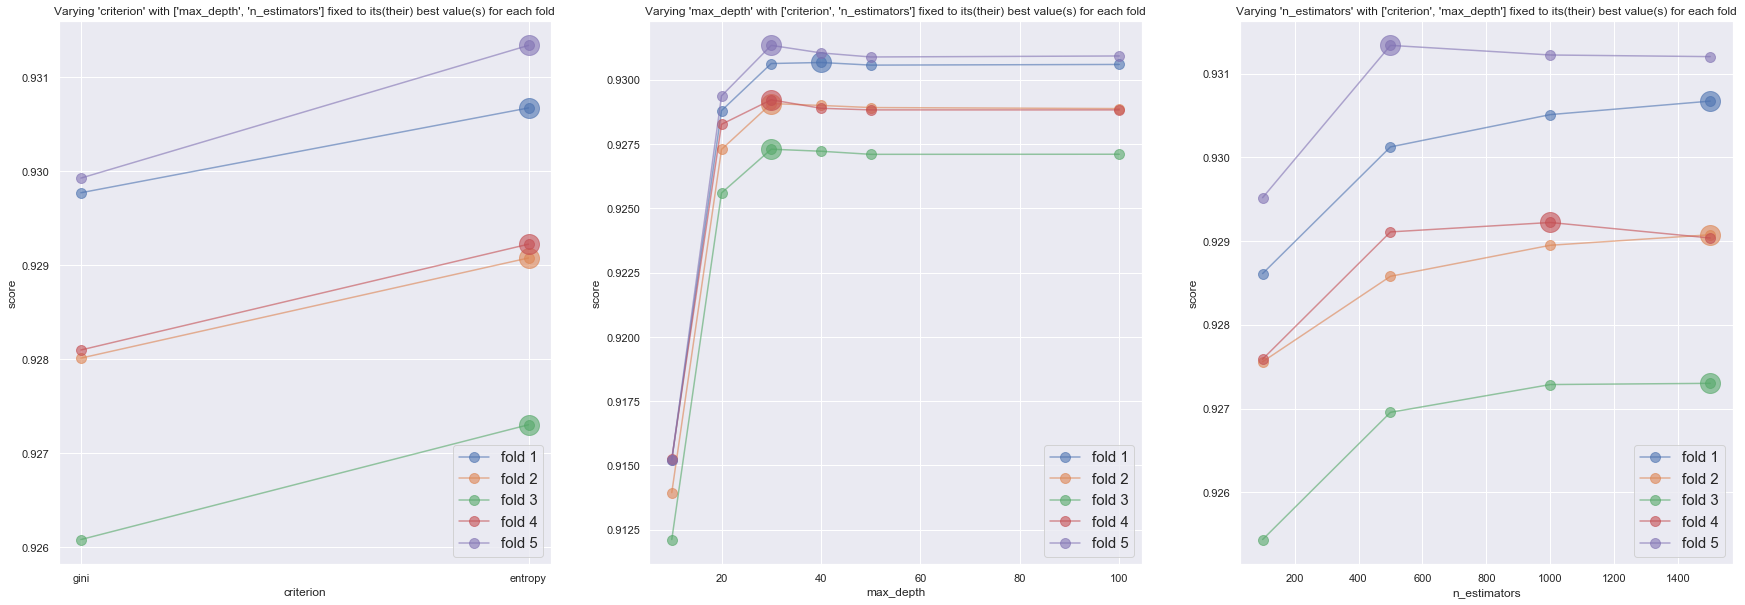

**RandomForest_sampling_3**

3 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → criterion   : ['entropy' 'gini']
  → max_depth   : [10 20 30 40 50 100]
  → n_estimators: [100 500 1000 1500]
Best hyperparameters for each fold:
fold 0: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1500}
fold 1: {'criterion': 'entropy', 'max_depth': 40, 'n_estimators': 1500}
fold 2: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1000}
fold 3: {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 1000}
fold 4: {'criterion': 'entropy', 'max_depth': 40, 'n_estimators': 1500}


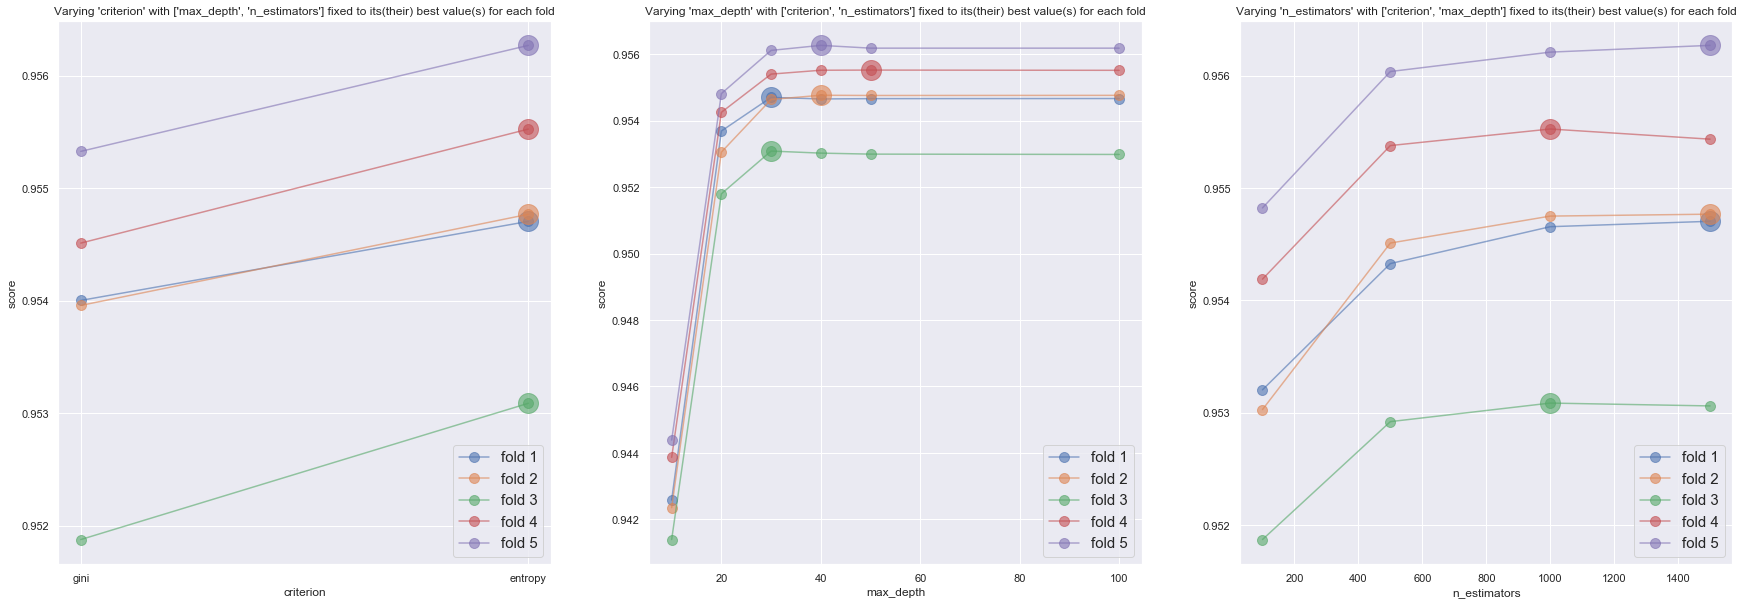

In [15]:
for job in job_list:
    if hasattr(job, 'metrics'):
        print_md('**' + job.job_id + '**')
        plot_grid_search_results(job.metrics, plot_error_bar=False)
        plt.show()

In [16]:
for job in job_list:
    if hasattr(job, 'metrics'):
        summary.loc[job.job_id] = [job.metrics.test_accuracy.mean(), job.metrics.test_roc_auc.mean(), job.metrics.test_f1.mean(), job.metrics.test_average_precision.mean()]

### Study feature importance of the best hyperparameted classifier

**sampling_1**

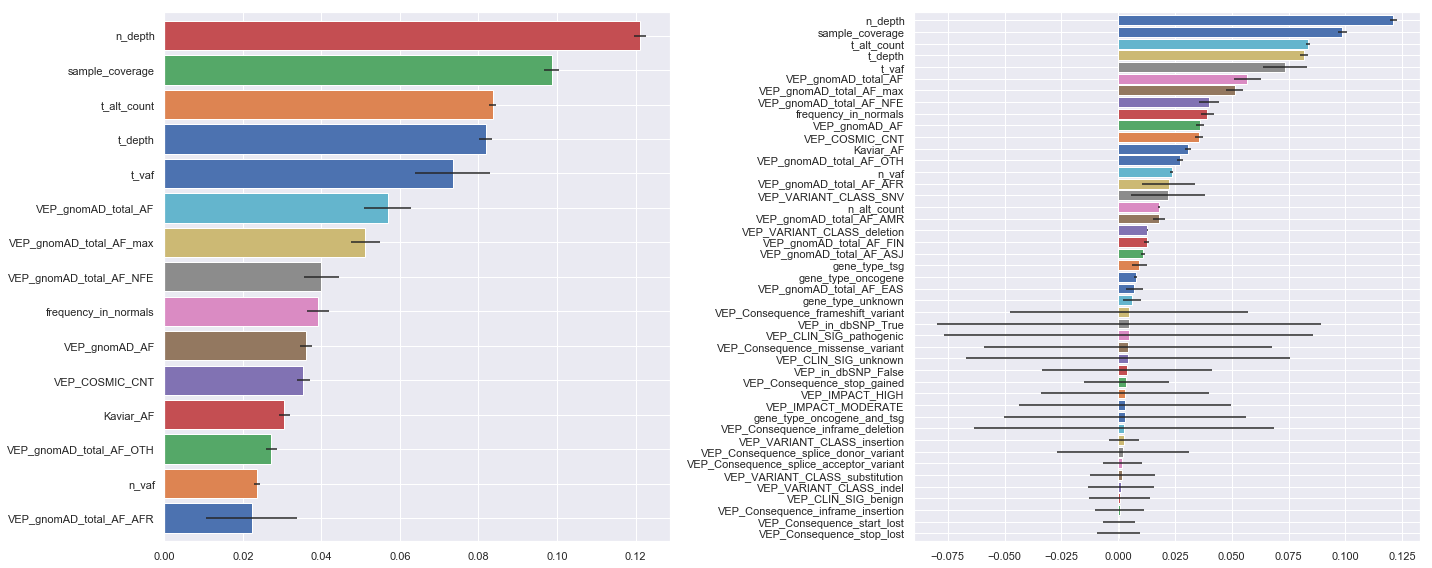

**sampling_2**

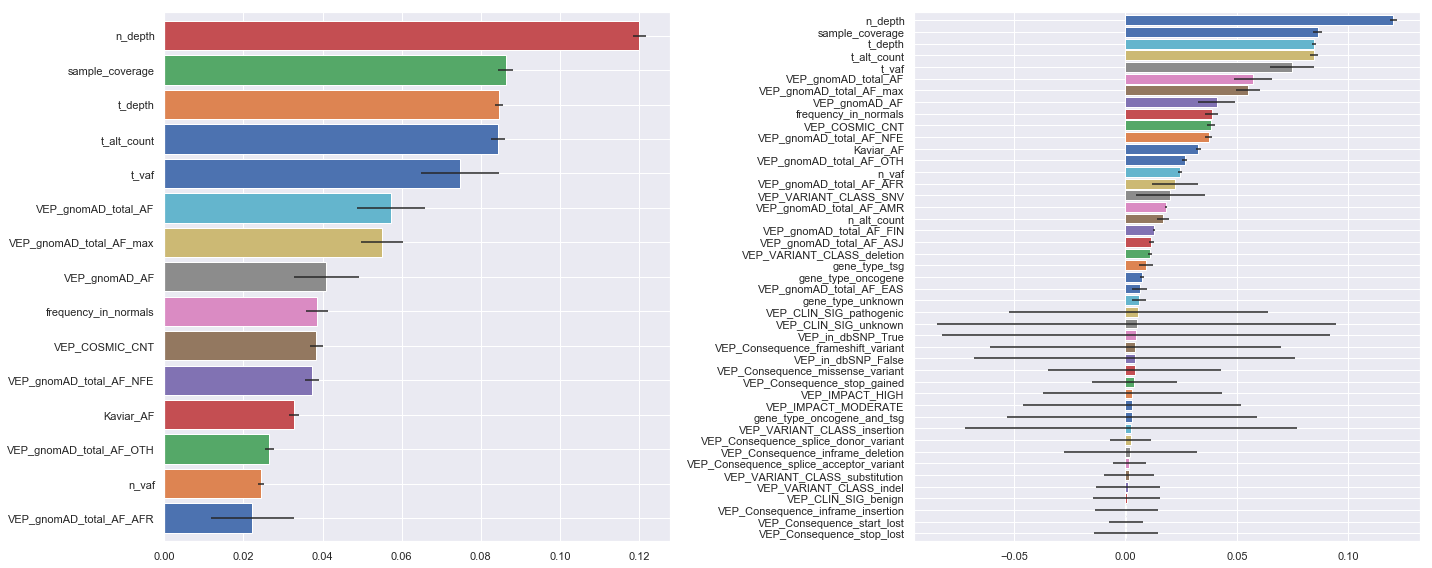

**sampling_3**

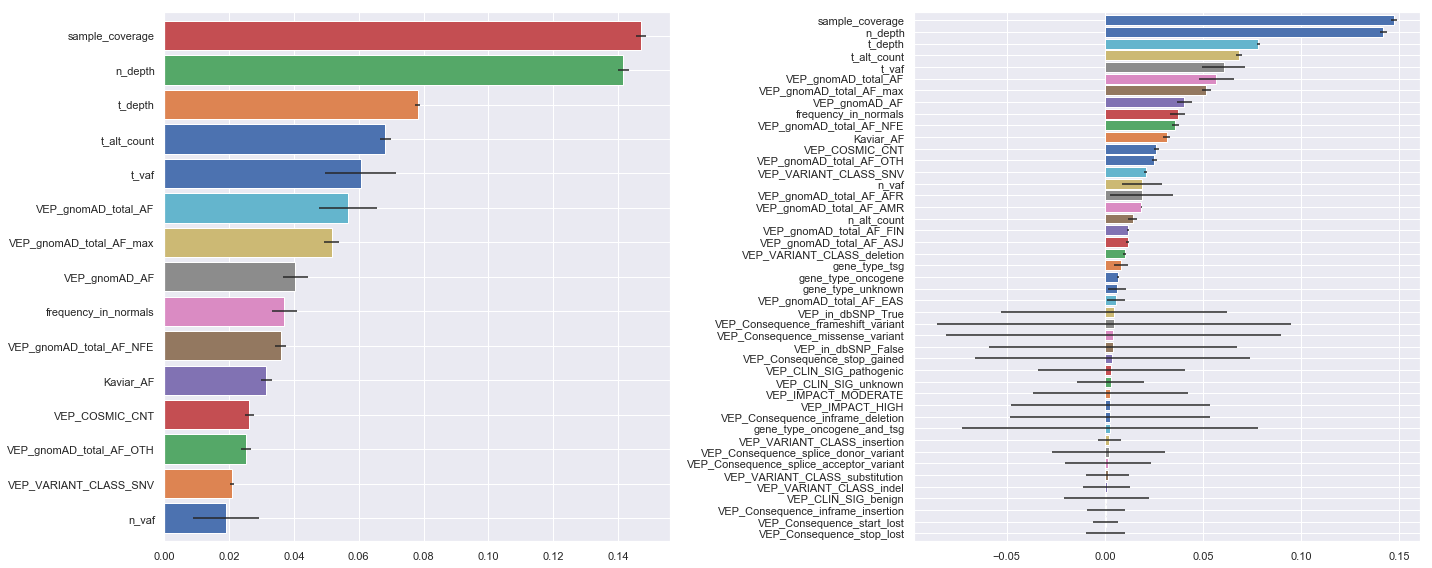

In [17]:
from sklearn.ensemble import RandomForestClassifier

model_bestRF = RandomForestClassifier(random_state=42, n_estimators=1000, max_depth=30, criterion='entropy', n_jobs=5)

for dataset_name, (X, y) in dataset_dict.items():
    print_md('**' + dataset_name + '**')

    model_bestRF.fit(X, y);
    
    feature_importance = pd.DataFrame({'value': model_bestRF.feature_importances_.tolist()}, index=X.columns.tolist())
    feature_importance.sort_values(by='value', axis=0, inplace=True)

    feature_importance['inter_tree_variability'] = np.std([tree.feature_importances_ for tree in model_bestRF.estimators_], axis=0)

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    feature_importance.tail(15).value.plot.barh(width=0.85, xerr=feature_importance.tail(15).inter_tree_variability)
    plt.subplot(1, 2, 2)
    feature_importance.value.plot.barh(width=0.85, xerr=feature_importance.inter_tree_variability)
    plt.tight_layout()
    
    plt.show()

## Summary

In [2]:
summary = pd.read_pickle('summary_sampling_comparison.pkl')

,test_accuracy,test_roc_auc,test_f1,test_average_precision
sampling_strategy,,,,
RandomForest_sampling_1,0.864,0.937,0.859,0.948
RandomForest_sampling_2,0.86,0.933,0.853,0.944
RandomForest_sampling_3,0.896,0.958,0.894,0.964
RidgeRegression_sampling_1,0.82,0.891,0.803,0.912
RidgeRegression_sampling_2,0.819,0.887,0.801,0.912
RidgeRegression_sampling_3,0.866,0.926,0.858,0.943


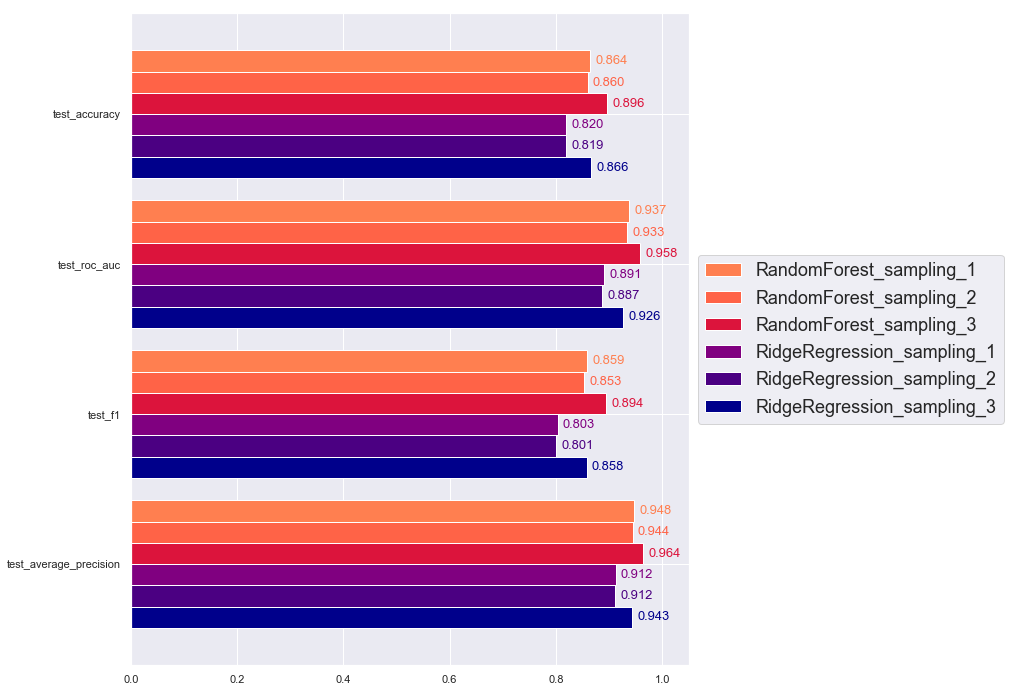

In [23]:
compare_models(summary, ['darkblue', 'indigo', 'purple', 'crimson', 'tomato', 'coral'])

In [24]:
summary.to_pickle('summary_sampling_comparison.pkl')